# Regularizations

### Generate points with the model y = ax+b+ε where epsilon is standard gaussian. x is distributed as uniform rv between [0,10]. Train a linear regression model with following polynomials
### • 2
### • 5
### • 10
### Study the out of sample performance for each of the above. Compare this when training dataset size is changed.

### Importing Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from time import time
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


### Polynomial Regression Class

In [ ]:
class Polynomial_Regression():
    def __init__(self, size=100, order=10, a=0.05, b=0.1):
        self.X, self.X_test, self.y, self.y_test, self.X_val, self.y_val = [], [], [], [], [], []
        self.W = []  
        self.a = a
        self.b = b
        self.order = order
        self.size = size
        # X is uniform from 0 to 10 [0, 10]
        self.maximum_of_X = 10  
        self.data_generation_function()

     # SYNTHETIC DATA GENERATION 

     # y = a*x + b + Epsilon
    def data_generation_function(self):

        # X is uniformly distributed ~ Unif(0, 10)
        self.X = np.random.uniform(0.0001, 10., self.size)
        self.X = np.array(sorted(self.X))
        self.y = self.a * self.X + self.b + \
            np.random.standard_normal(self.size) 
        self.y = self.y.reshape(-1, 1)

        # To avoid OVER-FLOW error during gradient-descent
        self.X = self.X/max(self.X)

        # generate nth order polynomial features
        self.X = np.array([self.X**i for i in range(0, self.order+1)]).T

        # Test-Train Split

        indexes = np.arange(len(self.X))
        np.random.shuffle(indexes)
        # Test Data size if 40% of the dataset
        test_data_size = int(0.4*len(self.X))

        x_test_indexes = sorted(indexes[-test_data_size:])
        x_train_indexes = sorted(indexes[:-test_data_size])

        self.X_test = self.X[x_test_indexes, :]
        self.y_test = self.y[x_test_indexes, :]

        self.X = self.X[x_train_indexes, :]
        self.y = self.y[x_train_indexes, :]

  
    def loss_function_no_reg(self):
        total_loss = (1/2)*((self.X@self.W - self.y).T)@(self.X@self.W - self.y)
        total_loss = total_loss.reshape(1)[0]
        return total_loss

    def gradient_no_regularisation(self):
        gradient_no_reg = self.X.T@(self.X@self.W - self.y)
        return gradient_no_reg

    # Computing Alpha (Regularization parameter)
    def compute_alpha(self):
        gradient = self.gradient_no_regularisation()
        final_alpha = np.linalg.norm(gradient)**2 / (gradient.T@(self.X.T@self.X)@gradient)
        final_alpha = final_alpha[0]
        return final_alpha

    # Loss: Ridge Regression 
    def ridge_regression_loss(self, lambda_):
        loss = self.loss_function_no_reg() + lambda_*(np.linalg.norm(self.W)**2)
        return loss

    def ridge_regression_gradient(self, lambda_):
        gradient = self.gradient_no_regularisation() + 2*lambda_*self.W
        return gradient

    # Computing Alpha (Regularization parameter): Ridge Regression
    def compute_alpha_ridge(self, lambda_):
        gradient_ridge = self.ridge_regression_gradient(lambda_)
        final_alpha = np.linalg.norm(gradient_ridge)**2 / (gradient_ridge.T @
                                                 (self.X.T@self.X + lambda_*np.eye(len(self.X[0])))@gradient_ridge)
        final_alpha = final_alpha[0]
        return final_alpha

    # Loss: Lasso Regression
    def lasso_regression_loss(self, lambda_):
        loss = self.loss_function_no_reg() + lambda_*np.sum(np.abs(self.W))
        return loss

    # Computing Alpha (Regularization parameter): Lasso Regression
    def lasso_regression_gradient(self, lambda_):
        gradient_lasso = self.gradient_no_regularisation() + lambda_*(np.sign(self.W).reshape(-1, 1))
        return gradient_lasso

    # Loss: Elastic Regression
    def elastic_regression_loss(self, lambda_1, lambda_2):
        elastic_loss = self.loss_function_no_reg() + lambda_1*(np.linalg.norm(self.W)
                                                            ** 2) + lambda_2*np.sum(np.abs(self.W))
        return elastic_loss

    def elastic_regression_gradient(self, lambda_1, lambda_2):
        gradient_elastic = self.gradient_no_regularisation() + 2*lambda_1*self.W + lambda_2 * \
            (np.sign(self.W).reshape(-1, 1))
        return gradient_elastic

    def evaluate_out_of_sample_metrics(self):
        self.y_pred = self.X_test@self.W
        loss_out_of_sample = (1/2)*np.sum((self.y_pred - self.y_test)**2)
        return loss_out_of_sample

    def evaluate_in_sample_metrics(self):
        self.y_pred = self.X@self.W
        loss_in_sample = (1/2)*np.sum((self.y_pred - self.y)**2)
        return loss_in_sample

    def val_set_performance(self):
        y_pred = self.X_val@self.W
        loss = (1/2)*np.sum((y_pred - self.y_val)**2)
        return loss

    def plot_model(self, X, y):
        y_pred = X@self.W
        plt.scatter(X[:, 1]*10, y, alpha=0.2)
        plt.plot(X[:, 1]*10, y_pred)
        plt.show()

    def polynomial_gradient_descent(self, max_iter=100000, regularization_method=None, lambda_lasso=1e-3, lambda_ridge=1e-3, lambdas_elastic=[1e-3, 1e-3], show_results=True):
        # Using gradient descent and regularization, we are predicting desired polynomial that is its coefficients 
        count_of_iterations = 0
        error_threshold = 7e-2
        learning_rate = 0.006

        self.W = 5*np.random.rand(self.X.shape[1]).reshape(-1, 1)

        previous_loss = 1e+10

        while count_of_iterations < max_iter:
            count_of_iterations += 1
            if regularization_method == None:
                loss = self.loss_function_no_reg()
                gradient = self.gradient_no_regularisation()
                learning_rate = self.compute_alpha()
            elif regularization_method == 'ridge':
                loss = self.ridge_regression_loss(lambda_ridge)
                gradient = self.ridge_regression_gradient(lambda_ridge)
                learning_rate = self.compute_alpha_ridge(lambda_ridge)
            elif regularization_method == 'lasso':
                loss = self.lasso_regression_loss(lambda_lasso)
                gradient = self.lasso_regression_gradient(lambda_lasso)
            elif regularization_method == 'elastic_net':
                loss = self.elastic_regression_loss(*lambdas_elastic)
                gradient = self.elastic_regression_gradient(*lambdas_elastic)

            # break when loss starts increasing
            if (previous_loss < loss):
                if show_results:
                    print("Iteration : ", count_of_iterations)
                break

            # break when loss becomes tolerable
            if loss < error_threshold:
                if show_results:
                    print("Loss : ", loss, "Iteration : ", count_of_iterations)
                break

            # break when loss reachs convergence
            if (previous_loss - loss) < 1e-3:
                if show_results:
                    print("Minimum Loss: ", loss)
                break
            # updating previous loss to current loss
            previous_loss = loss

            # Update W
            self.W = self.W - learning_rate*gradient

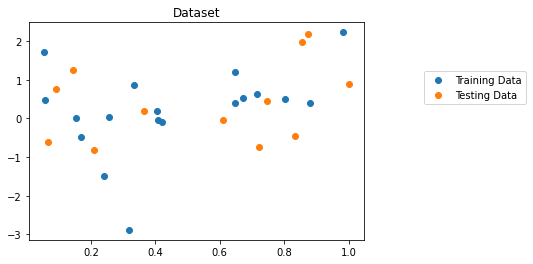

In [ ]:
size = 30
polynomial_regression_obj = Polynomial_Regression(size=30, order=10)
plt.title('Dataset')
plt.scatter(polynomial_regression_obj.X[:, 1], polynomial_regression_obj.y, label='Training Data')
plt.scatter(polynomial_regression_obj.X_test[:, 1], polynomial_regression_obj.y_test, label='Testing Data')
plt.legend(bbox_to_anchor=(1.5, 0.8))
plt.show()

### Change in fit with varying datasize and order of the polynomial


Minimum Loss:  9.58652340493438
In the sample loss :  9.58652340493438
Out of the sample loss : 15.338314388390057


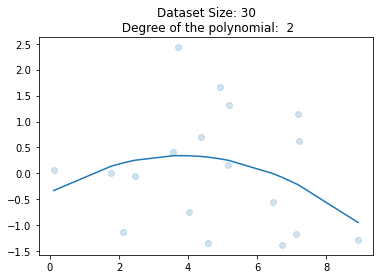

Minimum Loss:  6.432324712733556
In the sample loss :  6.432324712733557
Out of the sample loss : 19.380596609364247


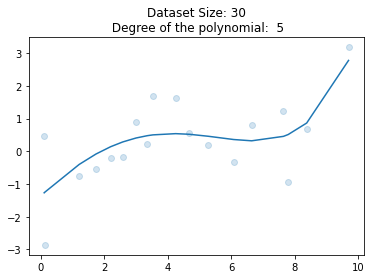

Minimum Loss:  8.890844273704344
In the sample loss :  8.890844273704342
Out of the sample loss : 6.923311923002735


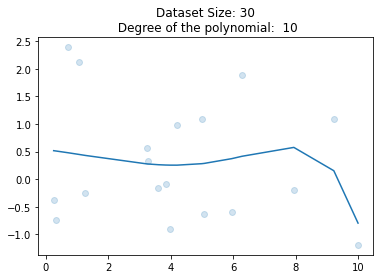

Minimum Loss:  24.270953490170267
In the sample loss :  24.270953490170264
Out of the sample loss : 9.135293443031221


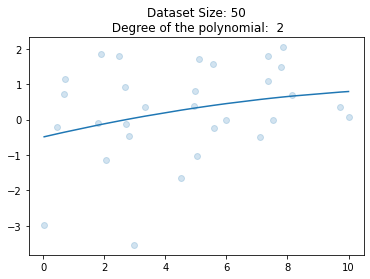

Minimum Loss:  13.511990983280665
In the sample loss :  13.511990983280661
Out of the sample loss : 13.68384677113902


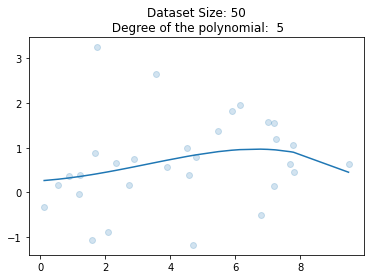

Minimum Loss:  16.970449589412638
In the sample loss :  16.970449589412635
Out of the sample loss : 10.406197805056097


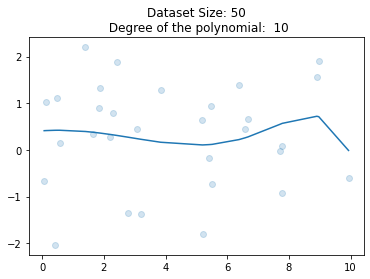

In [ ]:
orders= [2, 5, 10]
sizes = [30, 50]
for s in sizes:
    for o in orders:
        polynomial_regression_obj = Polynomial_Regression(size=s, order=o)
        polynomial_regression_obj.polynomial_gradient_descent()
        print("In the sample loss : ", polynomial_regression_obj.evaluate_in_sample_metrics())
        print("Out of the sample loss :", polynomial_regression_obj.evaluate_out_of_sample_metrics())
        plt.title("Dataset Size: %d\n" % s + " Degree of the polynomial:  %d" % o)
        polynomial_regression_obj.plot_model(polynomial_regression_obj.X, polynomial_regression_obj.y)

### Variation of errors list w.r.t dataset sizes

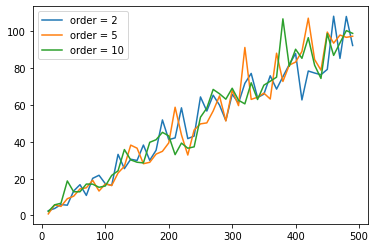

In [ ]:
orders = [2, 5, 10]
sizes = np.arange(10, 500, 10)
errors_list = np.zeros((len(sizes), len(orders)))
for i, s in enumerate(sizes):
    for j, o in enumerate(orders):
        polynomial_regression_obj = Polynomial_Regression(size=s, order=o)
        polynomial_regression_obj.polynomial_gradient_descent(show_results=False)
        errors_list[i, j] = polynomial_regression_obj.evaluate_out_of_sample_metrics()
for j in range(len(orders)):
    plt.plot(sizes, errors_list[:, j], label='order = '+str(orders[j]))
plt.legend()
plt.show()

### Observe how the coeffients change via a plot for different values of regularization constant.

In [ ]:
def plot_variation_coefficient_vs_regularization(regularization_method='ridge'):
    coefficients_list = []
    size = 30
    order = 10
    regularization_parameters = np.array([10**i for i in range(-5, 3)])
    for reg_param in regularization_parameters:
        polynomial_regression_obj = Polynomial_Regression(size=size, order=order)
        if regularization_method == 'ridge':
            polynomial_regression_obj.polynomial_gradient_descent(regularization_method=regularization_method,
                                lambda_ridge=reg_param, show_results=False)
        elif regularization_method == 'lasso':
            polynomial_regression_obj.polynomial_gradient_descent(regularization_method=regularization_method,
                                lambda_lasso=reg_param, show_results=False)
        elif regularization_method == 'elastic_net':
            polynomial_regression_obj.polynomial_gradient_descent(regularization_method=regularization_method,
                                lambdas_elastic=reg_param, show_results=False)

        coefficients_list.append(polynomial_regression_obj.W.reshape(-1))
    coefficients_list = np.array(coefficients_list)

    plt.figure(figsize=(20, 10))
    plt.title('Change in the coefficients w.r.t. regularization is' +
              regularization_method + ' regression')
    for i in range(coefficients_list.shape[1]):
        x, y = np.log10(regularization_parameters), coefficients_list[:, i]
        plt.plot(x, y, label='W_'+str(i))
    plt.legend(loc='upper right')
    plt.show()

### Ridge Regression

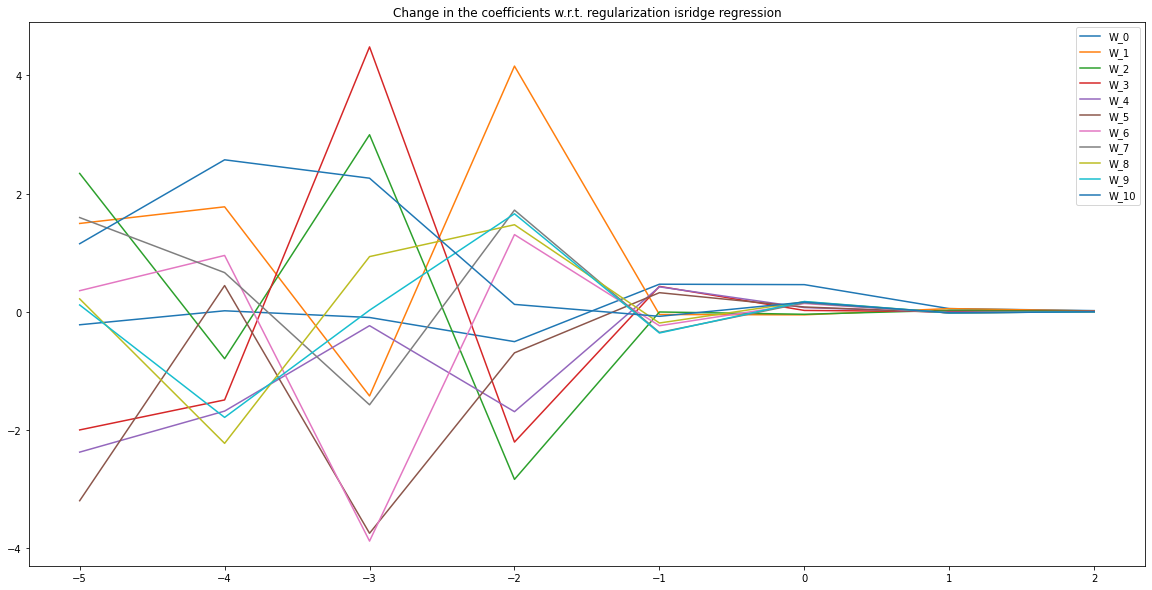

In [ ]:
plot_variation_coefficient_vs_regularization('ridge')

### Lasso Regression

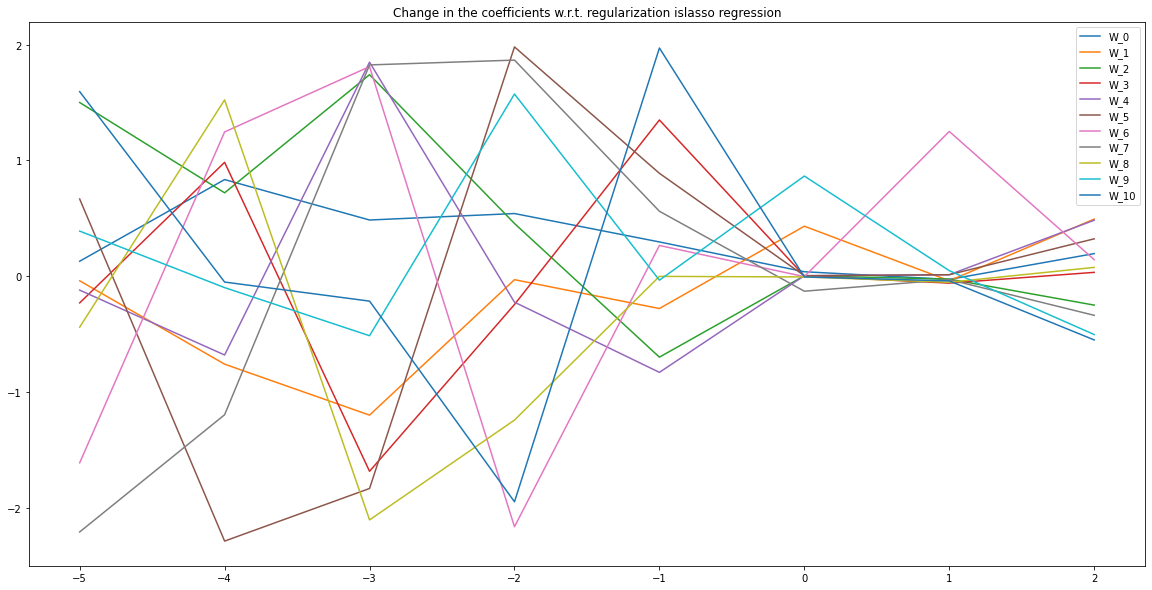

In [ ]:
plot_variation_coefficient_vs_regularization('lasso')

### Using a validation approach fix a regularization constant. Implement a six-fold cross validation method for fixing regularization constant.

In [ ]:
# kf = KFold(n_splits=6)

### K Fold Function (Reference: Kaggle)

In [ ]:
def KFold_Function(max_iter=10000, K=6, reg_method='ridge', lambdas=[]):
    loss_list = []
    size = 30
    order = 10
    for _ in range(5):
        print(_)
        polynomial_regression_obj = Polynomial_Regression(size=size, order=order)
        X_train = polynomial_regression_obj.X.copy()
        y_train = polynomial_regression_obj.y.copy()
        loss_reg_params_list = []
        for reg_params in lambdas:
            losses_fold = []
            for fold in range(6):
                polynomial_regression_obj.X = X_train.copy()
                polynomial_regression_obj.y = y_train.copy()

                val_sz = int(len(polynomial_regression_obj.X)*(1/6))

                indexes = list(np.arange(len(polynomial_regression_obj.X)).reshape(-1))
                x_indx_val = indexes[fold*val_sz: (fold+1)*val_sz]
                del indexes[fold*val_sz: (fold+1)*val_sz]
                x_train_indexes = indexes
                polynomial_regression_obj.X_val = polynomial_regression_obj.X[fold*val_sz: (fold+1)*val_sz, :]
                polynomial_regression_obj.y_val = polynomial_regression_obj.y[fold*val_sz: (fold+1)*val_sz, :]
                polynomial_regression_obj.X = polynomial_regression_obj.X[x_train_indexes, :]
                polynomial_regression_obj.y = polynomial_regression_obj.y[x_train_indexes, :]
                
                if reg_method == 'ridge':
                    polynomial_regression_obj.polynomial_gradient_descent(max_iter=max_iter, regularization_method=reg_method, lambda_ridge=reg_params[
                                        0], show_results=False)
                elif reg_method == 'lasso':
                    polynomial_regression_obj.polynomial_gradient_descent(max_iter=max_iter, regularization_method=reg_method, lambda_lasso=reg_params[
                                        0], show_results=False)
                elif reg_method == 'elastic_net':
                    polynomial_regression_obj.polynomial_gradient_descent(
                        max_iter=max_iter, regularization_method=reg_method, lambdas_elastic=reg_params, show_results=False)

                loss = polynomial_regression_obj.val_set_performance()

                losses_fold.append(loss)

            loss_reg_params_list.append(np.mean(losses_fold))
        loss_list.append(loss_reg_params_list)
    loss_list = np.array(loss_list)
    loss_list = np.mean(loss_list, axis=0)
    return loss_list

### Finding the best regularization parameter

In [ ]:
def best_regularisation_parameter(lambdas, avg_loss_lambdas):
    min_loss = avg_loss_lambdas[0]
    reg_params_best = lambdas[0]
    for i, reg_param in enumerate(lambdas):
        if avg_loss_lambdas[i] < min_loss:
            reg_params_best = reg_param
            min_loss = avg_loss_lambdas[i]

    return reg_params_best

### Ridge Regression

In [ ]:
maximum_iterations = 1000

In [ ]:
lambdas = np.array([[10**i] for i in range(-5,3)])
mean_loss_ridge = KFold_Function(max_iter=maximum_iterations, reg_method='ridge',lambdas=lambdas)

0
1
2
3
4


In [ ]:
lambdas = np.array([[10**i] for i in range(-5, 3)])
best_reg_param_ridge = best_regularisation_parameter(lambdas, mean_loss_ridge)
print("Best Lambda for ridge regularization : ", *best_reg_param_ridge)

Best Lambda for ridge regularization :  10.0


Minimum Loss:  6.8125690179497935
In sample loss:  6.505676560232573
Out of sample loss: 6.190982844209377


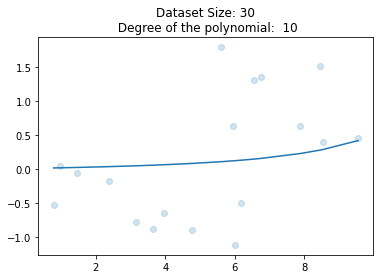

In [ ]:
s = 30
o = 10
polynomial_reg_obj = Polynomial_Regression(size=s, order=o)
polynomial_reg_obj.polynomial_gradient_descent(max_iter=maximum_iterations, regularization_method='ridge',
                    lambda_ridge=best_reg_param_ridge[0])
print("In sample loss: ", polynomial_reg_obj.evaluate_in_sample_metrics())
print("Out of sample loss:", polynomial_reg_obj.evaluate_out_of_sample_metrics())
plt.title("Dataset Size: %d\n" % s + " Degree of the polynomial:  %d" % o)

polynomial_reg_obj.plot_model(polynomial_reg_obj.X, polynomial_reg_obj.y)


### Lasso Regularization


In [ ]:
reg_parameters = np.array([[10**i] for i in range(-5,3)])
mean_loss_lasso = KFold_Function(max_iter=maximum_iterations, reg_method='lasso',lambdas=reg_parameters)

0
1
2
3
4


In [ ]:
reg_parameters = np.array([[10**i] for i in range(-5, 3)])
best_reg_param_lasso = best_regularisation_parameter(reg_parameters, mean_loss_lasso)
print("Best Lambda for lasso regularization : ", *best_reg_param_lasso)

Best Lambda for lasso regularization :  10.0


Minimum Loss:  8.814002569562662
In sample loss:  8.805500496099755
Out of sample loss: 11.794811067531933


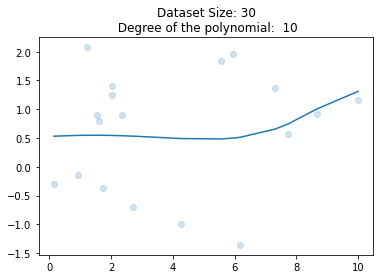

In [ ]:
s = 30
o = 10
polynomial_reg_obj = Polynomial_Regression(size=s, order=o)
polynomial_reg_obj.polynomial_gradient_descent(max_iter=maximum_iterations, regularization_method='lasso',
                                               lambda_ridge=best_reg_param_ridge[0])
print("In sample loss: ", polynomial_reg_obj.evaluate_in_sample_metrics())
print("Out of sample loss:", polynomial_reg_obj.evaluate_out_of_sample_metrics())
plt.title("Dataset Size: %d\n" % s + " Degree of the polynomial:  %d" % o)

polynomial_reg_obj.plot_model(polynomial_reg_obj.X, polynomial_reg_obj.y)

### Elastic Net Regularization

In [ ]:
max_iter = 10000 
lambdas = np.array( [ [10**i, 10**j] for i in range(-5,3) for j in range(-5,3)])
mean_loss_elastic = KFold_Function(max_iter=max_iter,reg_method='elastic_net', lambdas=lambdas)

0
1
2
3
4


In [ ]:
reg_parameters = np.array([[10**i, 10**k] for i in range(-5, 3) for k in range(-5, 3)])
best_reg_param_elastic = best_regularisation_parameter(
    reg_parameters, mean_loss_elastic)
print("Best Lambda for ridge regularization : ", *best_reg_param_elastic)

Best Lambda for ridge regularization :  100.0 10.0


Iteration :  9
In sample loss :  9.964713212502142
Out of sample loss : 5.033325550277158


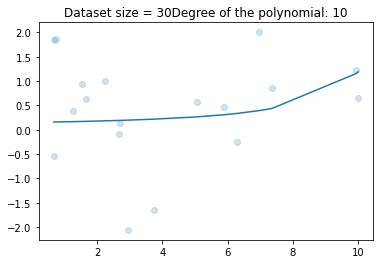

In [ ]:
s = 30
o = 10
polynomial_regression_obj = Polynomial_Regression(size=s, order=o)
polynomial_regression_obj.polynomial_gradient_descent(max_iter=max_iter, regularization_method='elastic_net',
                    lambdas_elastic=best_reg_param_elastic)
print("In sample loss : ", polynomial_regression_obj.evaluate_in_sample_metrics())
print("Out of sample loss :", polynomial_regression_obj.evaluate_out_of_sample_metrics())
plt.title("Dataset size = %d" % s + "Degree of the polynomial: %d" % o)
polynomial_regression_obj.plot_model(polynomial_regression_obj.X, polynomial_regression_obj.y)
